<a href="https://colab.research.google.com/github/SeanOnamade/BasicProjects/blob/main/03_1_Training_a_Neural_Network_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a small neural network in PyTorch

The aim of this notebook is to demonstrate how to train a small neural network in PyTorch using a toy example.

We'll start off by covering some of the basic building blocks of the training routine: (auto) differentiation, loss functions, optimisation. After introducing these concepts we'll put them together in a simple training routine.

**Table of Contents**
1. [Neural Network Building Blocks](#nn_building_blocks)
2. [Lightweight Training Routine](#training_loop)
3. [Conclusion](#conclusion)

## <a name="nn_building_blocks"> 1. Neural Network Building Blocks</a>

Before getting into a simple training loop, we'll cover some of the core components required for neural networks to learn representations of data and before we dive into the theory we'll contextualise some of how neural networks learn using an example.

### Training Components
Before diving into the below content, I highly recommend watching 3blue1brown's [lesson](https://www.3blue1brown.com/lessons/gradient-descent) gradient descent. The video and accompanying blog are an excellent resource and many of the images below are sourced from the blog. Before we dive into the theory, consider the below example that feeds a 28x28 image into a simple linear neural network. The pixels in the image are unrolled into an input array (tensor) of size 784 (28 x 28).

![example_net](./resources/simple-torch/net_example.png)

Before training the network, it's possible to receive predictions but the weights of the neural network have been randomly initialised and so the output will be garbage. You can see this in the above image where the brighter weight circles represent higher values and in the final output layer the model has no idea which number the input represents.

Backpropagation is the primary algorithm used to train neural networks. It's outside the scope of this intro tutorial to dive into the weeds of how backpropagation works but [3blue1brown](https://www.3blue1brown.com/lessons/backpropagation) comes to our rescue again if you would like to dig a little deeper on backprop. Backprop works by calculating the error between the predicted output and the actual output and propagating this error back through the neural network from the last layer to the first. Backprop calculates the gradient of the loss function with respect to each weight in the network using basic calculus techniques like the chain rule. These gradients indicate how much each weight contributed to the error and these weights are then adjusted to attempt to minimise the error on the next forward pass.

#### Loss functions (also known as a Cost function)

You might be wondering how the error in the backwards propagation step is calculated. This is where the loss function comes in, for a simple toy example we could consider the loss function to be the `loss = ((predictions - labels)**2).sum()`, or in plain english the sum of the squared deltas between predictions and actuals. PyTorch offers many [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) for a variety of tasks so there is often no need to manually define how the loss is calculated.

Let's contextualise this using the 3blue1brown example again. The image below shows the cost calculation for a single example. In this image we can see the cost calculation for a single input. During training this is calculated for many thousands of inputs.

![cost_fn_example](./resources/simple-torch/cost_fn_example.png)

Once this loss has been calculated it can be propagated back through the network by calling `loss.backward()`. Okay great, so we've calculated the error and propagated it back through the network so that it's stored in the NN tensors `.grad` parameter but how do we update the weights? That's where optimisation comes in.

#### Optimisers

Optimisation is the step by which the weights (parameters) in the neural network are updated. The goal of the optimiser is typically to minimise the loss criteria by updating the model weights. Pytorch also provides many popular [optimisation algorithms](https://pytorch.org/docs/stable/optim.html#algorithms) but today we will focus on Stochastic Gradient Descent (SGD) which can be represented as follows:

`weight = weight - learning_rate * gradient`

Learning rate is an important parameter that is defined when you initialise your optimiser and as the name suggests it controls the rate at which the weights in your network are updated. Larger learning rates mean bigger updates to your network at each step which could lead to quicker convergence, too large a learning rate may make it difficult for your model to converge at all. Smaller learning rates make more iterative updates to your model weights but increase the number of training steps required, too small a learning rate could lead to your model getting stuck in a local minima. The following image is useful for visualising learning rate:

![lr](./resources/simple-torch/learning-rate.png)

#### Auto Differentiation

Autodiff greatly simplifies the training process for developers by enabling efficient computation of the derivatives in the neural networks computational graph. Autodiff keeps track of all tensor operations during the forward pass to build the computational graph then during the backward pass the gradients of the loss function with respect to all tensors is computed using the chain rule.

Pytorch's automatic differentiation engine is `torch.autograd` and it powers all neural network training in torch. Neural Networks are a collection of nested functions which takes in some input data and return an output tensor. The parameters of these functions are the weights and biases of the neural network. Training takes place in two steps:

* __Forward propagation__: Input data is passed through each function in the Neural Network which the network uses to make it's best guess about the output data.
    + __Inference__: During inference, only forward propagation is used.
* __Backward propagation__:  In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing the parameters using gradient descent in a separate step.

This is all we need to start training but if you want to read more about autograd or computation graphs you can check out the official PyTorch [tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#differentiation-in-autograd).

## <a name="training_loop">2. Neural Network Building Blocks</a>

A typical training procedure for a neural network is as follows:

* Define the neural network that has some learnable parameters (or weights)
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

Some additional nomenclature which is useful:

* epoch: one pass through the entire training dataset
* step: a single forward pass through the model (e.g., one batch size update)

### 2.a Defining the dataset and problem

So for this tutorial we will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset available through torchvision.The CIFAR-10 dataset was collected and released by researchers at the University of Toronto and contains 60,000 32x32 images separate into 10 different classes. The classes in this case are different real world objects: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. We hope that by training our neural network it will learn to take the pixels of the image as input and predict the correct class.

Much of the code is borrowed from the [Training A Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) tutorial available on PyTorch's website. Using this dataset simplifies some of the manual processing required to get our data ready for training.

In the below code block, there are a number of important steps to note:

* First a set of transforms are defined that will be applied to training data.
    + `transforms.Compose` takes a list of pre-defined transformations that will be applied to each image in the dataset.
    + We define two transforms: `ToTensor` which converts arrays to tensors and `Normalize` which normalises the RGB values of the images
* Next we define a `batch_size` which is the number of images that will be passed to the neural network `for` each training step.
* Then we load the CIFAR10 datasets for training and testing and pass them to a DataLoader with `batch_size`
    + `DataLoader`s provide convenient functionality for looping over each batch of images in the training data
* Finally we define the class names


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Set a seed for reproducibility
torch.manual_seed(42)

transform = transforms.Compose(
    [transforms.ToTensor(), # Convert arrays to Tensors
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # apply normalisation to the image array

batch_size = 4

# Define the dataset and dataloaders used for training and testing
trainset = torchvision.datasets.CIFAR10(
    root='./data', # Where will the data be saved
    train=True, # boolean to select the train split
    download=True, # Download data
    transform=transform # Transforms to be applied, defined above.
)
trainloader = torch.utils.data.DataLoader(
    trainset, # dataset to use when creating the dataloader
    batch_size=batch_size, # Batch size, number of images to load at each step
    shuffle=True, # Whether or not the order of the samples should be shuffled
    num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48257750.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's quickly inspect the data so that we can see what we are working with.

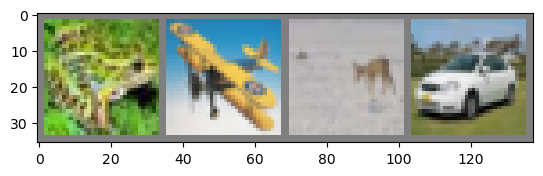

frog  plane deer  car  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2.b Defining a simple neural network in PyTorch

PyTorch provides a `Module` class which is the core workhorse of the torch neural networks. This Module class abstracts away many of the tensor operations required to train and update a neural network as outlined in the above section. Our neural network will be a subclass of the Module class where our network is defined in the `__init__` method and the flow of data through the network is defined in the `forward` method.

Below is a simple convolution net that uses the following neural network layers `nn.Conv2d, nn.MaxPool2d, nn.Linear`.

We won't get too much into the theory of convolutional neural networks in this tutorial but if you are interested in learning more this is an excellent, albeit old, blog [post](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2,
                                 stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5,
                             out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Training

We've defined our neural network in PyTorch along with our dataset and dataloaders. In the next sections we will define our loss criteria, optimizer and training and evaluation functions.


### Define a loss function and optimizer

As a loss function we will use `nn.CrossEntropyLoss`. Cross entropy loss is a common loss function for multiclass classification problems and suitable for a wide range of problems. In a nutshell, cross entropy loss measures the the difference between two probability distributions. The higher the loss, the more the model's predictions differ from the true label, so we try to minimize this loss.

As our optimizer, we will use Stochastic Gradient Descent (`optim.SGD`) to update the weights of the neural network with a learning rate of 1e-3

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Next we'll define a function to train the network for a fixed number of epochs.

[1,  2000] loss: 2.144
[1,  4000] loss: 1.831
[1,  6000] loss: 1.673
[1,  8000] loss: 1.568
[1, 10000] loss: 1.517
[1, 12000] loss: 1.442
[2,  2000] loss: 1.396
[2,  4000] loss: 1.357
[2,  6000] loss: 1.326
[2,  8000] loss: 1.333
[2, 10000] loss: 1.298
[2, 12000] loss: 1.257


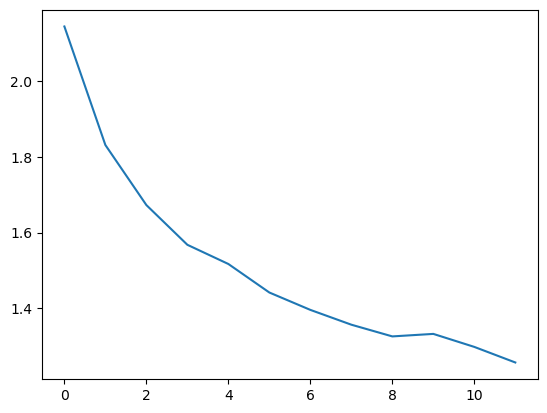

In [ ]:
def train_iter(epochs: int):
    """Train the neural network for a set number of epochs"""
    loss_array = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                loss_array.append(running_loss / 2000)
                running_loss = 0.0

    return loss_array

loss_array = train_iter(2)
plt.plot(range(len(loss_array)), loss_array)

From the chart above we can see how our loss decreases with each training step, decreasing rapidly at the beginning and then starting to level off as training continues resulting in diminishing returns.

### Evaluate the trained model

Okay, we've trained our model for 2 epochs. Let's test it out on some of the data the model hasn't seen before which is in our testloader. We'll start by printing out the images so we can manual inspect them and then generating class labels from the model.

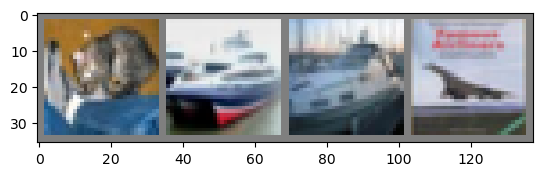

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = net.eval()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  bird  ship  ship  ship 


Okay, the model performance is pretty poor with only one correct prediction but this isn't too surprising having only completed two epochs of training.

Let's calculate the accuracy on the overall test set by defining a function to iterate through the entire `testloader`. This function looks very similar to our training function with a couple of key differences. Firstly, all operations are wrapped in the `torch.no_grad()` context manager which disables torch's autograd engine preventing backpropagation which we do not want during evaluation. Secondly, the loss calculation and backward pass have also been removed.

In [ ]:
def evaluate_iter():
    """Calculate performance on the test set."""
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

evaluate_iter()

Accuracy of the network on the 10000 test images: 56 %


At a first glance, an accuracy of 55% seems pretty terrible and it is! However, it's important to remember that there are 10 classes with an even distribution, so the accuracy if we just randomly guessed the class for a given image would be ~10%. Our model is already much better than random guessing. This baseline is calculated because we know that the CIFAR-10 dataset is uniformly distributed so if we randomly guessed an outcome we would get the right answer approximately 10% of the time.

#### A quick note on baselines

Establishing a baseline is an important best practice and helps us to know if a model is adding value. Baselines can come from a number of sources:

1. A prior version of the model
    + If the project you are working on already has a model in production then you have a baseline. That baseline is the performance of the prior version
2. If this is a net new project there are a number of ways to quickly establish a baseline
    + Using random guessing as described above
    + Training a simple logistic regression or tree based classifier (e.g., a decision tree) and evaluating the performance

Baselines are important not only because they give us insight into how much value the model is adding but they can help us make decisions about when to ship a model versus continuing to iterate. For example, our above model achieves 56% accuracy which doesn't sound great on face value but what if was 80%? This is significantly better then random guessing and our first iteration of 56%. Would we be comfortable deploying this model now rather than striving for 99%? This often depends on the use-case.

⚒️ **Homework** ⚒️

Experiment with the model architecture and improve on the accuracy metric of 55%. Some ideas to try:

* Increase the number of training epochs
* Increase the number of out channels calculated as part of the convolution
    + Be careful as this changes the number of inputs required to the first `nn.Linear` layer, bonus points if you can figure out the relationship.
* Experiment with the learning rate to see how loss changes

Alternatively, as a harder challenge, try switching out the CIFAR10 dataset with another PyTorch-provided dataset and train an entirely new model. We recommend the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), since it is a relatively similar problem.

_Note: Some reminders, when evaluating model performance you need to set your neural network to `.train` mode and when evaluating you need to set the model to `.eval` to let your model know that it's in eval model, this disables things like dropout or other normalisation layers that we did not cover in this lesson. The model defaults to train mode when initialised._

## <a name="conclusion">Conclusion</a>

Well done, you've learned the basics of how to train a neural network in PyTorch! If you are interested in getting a more in-depth tutorial, we recommend you check out [PyTorch's beginner guide](https://pytorch.org/tutorials/beginner/basics/intro.html).

See you in the next one!